# PyCDA: Simple Sub-Km Crater Detection

PyCDA was built to make crater detection <I>simple</I>.

In [1]:
from pycda import CDA

/Users/mklear/miniconda3/envs/pycda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mklear/miniconda3/envs/pycda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Making a Prediction
We'll start with a simple greyscale image. This is an image of the Nanedi Vallis; the resolution is 12.5 meters per pixel, and the image is 1700x1700 pixels, or roughly 21km x 21km.

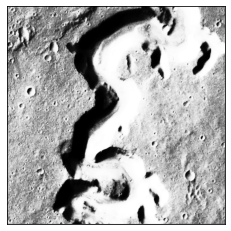

In [2]:
from pycda.sample_data import get_sample_image
image = get_sample_image()
image.show();

## Build a CDA Pipeline
PyCDA is designed to work "out of the box." That means you can simply instantiate the pipeline by calling the CDA class:

In [3]:
cda = CDA()

/Users/mklear/miniconda3/envs/pycda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Get Detections
Your CDA instance is loaded and ready to make detections! Call the .predict() method on an image to get crater annotations from your pipeline. The image in this example is a special PyCDA image class, but numpy arrays and PIL images are also supported in this alpha version.

In [4]:
detections = cda.predict(image)
detections.head(4)

,lat,long,diameter
0,21.0,30.0,44.021252
1,17.0,1165.0,49.789531
2,19.0,1320.0,44.323906
5,21.0,1680.0,30.298609


### Detection Format
The detections are returned in the form of a pandas dataframe; 'lat' is the vertical position of the detected crater from the top of the image, 'long' is its horizontal position from the left edge of the image. PyCDA models these small impact craters as circles, centered at (lat, long) with the given diameter (in pixels).

### Exporting Detections
The pandas dataframe makes it easy to convert your detections to a csv file. Simply call .to_csv(filename). If you want to exclude the numbered index column, use index=False:

In [5]:
detections.to_csv('~/Documents/my_file.csv', index=False)

## Inspecting Your Detections
Crater detection is difficult, and PyCDA is certainly not 100% accurate. It's a good idea to visually inspect the detections made by PyCDA. To make this easy, PyCDA includes a special Prediction class that draws detections over the input image with .show(). To get your Prediction object, just use the .get_prediction() method on your image. It should be quick; PyCDA remembers previous images to avoid repeating heavy computations.

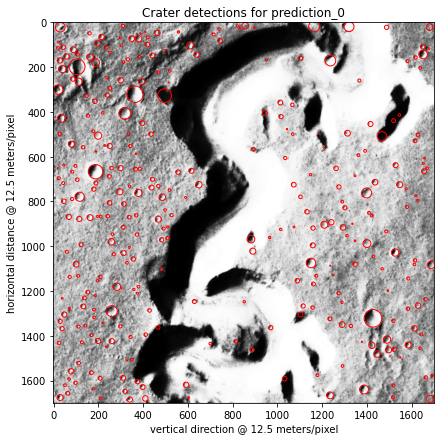

In [6]:
prediction = cda.get_prediction(image)
prediction.set_scale(12.5)
prediction.show()

We can see that the algorithm has made some good detections, and some bad ones, too. 

## Error Analysis

For research purposes, it's important to quantify the error rate of our CDA pipeline. The PyCDA error_stats submodule helps us do this. We can't perform an error analysis without known crater locations; you'll need to produce annotations to use this feature.<br><br>
Start by adding your known annotations to the prediction object. Use a pandas dataframe with the same format for known craters: 'lat', 'long', and 'diameter'.

In [7]:
from pycda.error_stats import ErrorAnalyzer
from pycda.sample_data import get_sample_csv

prediction.known_craters = get_sample_csv()
an = ErrorAnalyzer()
an.analyze(prediction)

220 craters were properly detected.
Matching complete!


Detection Percentage: 53.8%

Precision: 0.69

Recall: 0.54

F1-Score: 0.61

False Discovery Rate: 0.31

False Negative Rate: 0.46

Branching Factor:  0.44

Quality Percentage: 43.5% 



You'll get a printout of some error statistics. You can see we've detected close to 60% of the craters in our image, with a pretty even distribution of error types; our model seems slightly more prone to missing craters than presenting false detections, but both types of errors are present.

### Visualizing Errors

The ErrorAnalyzer object has some visualization tools; to see a map of detections, known craters, and matches, call .show():

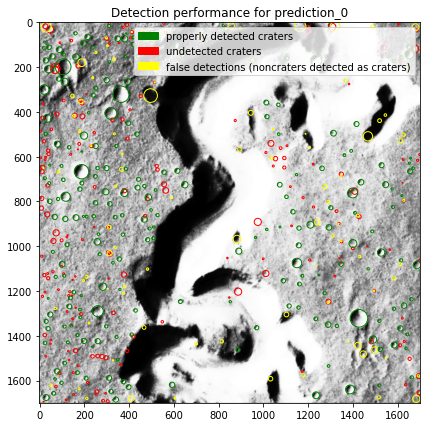

In [8]:
an.show()

To compare estimated to known crater counts by size, use .plot_densities():

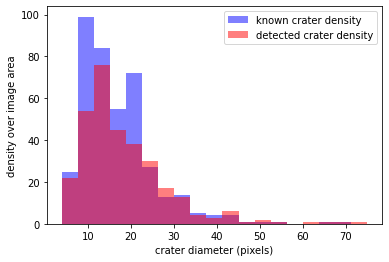

known crater count in image:  409
detected crater count in image:  317


In [9]:
an.plot_densities()

## Algorithm Function and Improving Performance

PyCDA produces detections using a three-step pipeline:

   1. Detection: The detector model makes a pixel-wise prediction.
   2. Extraction: A geometric model converts groups of pixels into crater proposals.
   3. Classification: A binary classifier inspects each proposal and decides if it is a crater or a false detection.<br>
   
Improving any one of these three steps can improve model performance.

### 1. Detection

The output of the detection model in our example looks like this:

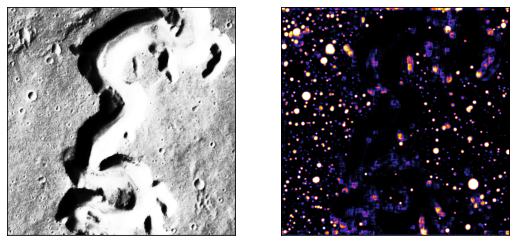

In [10]:
prediction.show_detection()

We can see the splotches where craters have been picked up by the model.<br>
PyCDA uses a "U-net" convolutional neural network to produce these detections; this type of model was selected because it gives highly location-specific predictions. It is implimented through keras and tensorflow under the hood.

### 2. Extraction
We've got a pretty map of potential craters. Extraction is the process of converting these splotches into simple, three-point detections: lat, long, and diameter.

By default, PyCDA models these splotches as circles; after binarizing the detection image, the extractor identifies independent groups of nonzero pixels. It then computes the centroid of these pixel groups and uses the number of pixels as the area of the circle to compute its diameter.

It's a simple approach and it works well... sometimes. Its biggest problem comes from "touching" craters, such as the tight group located in the upper-lefthand corner of our sample image. That's why you'll notice our detection map puts one big crater right in the center of that group.

An alternative approach is to use an image processing technique to identify unique "blobs" in a group of touching "blobs" called <a href='http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html'>watershed segmentation</a>. PyCDA comes with the option to use this technique as an alternative to the circle model.

/Users/mklear/miniconda3/envs/pycda/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


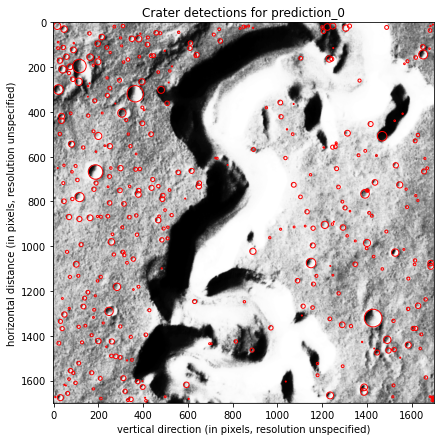

In [11]:
new_cda = CDA(extractor='watershed')
new_prediction = new_cda.get_prediction(image)
new_prediction.show()

It looks like that took care of the issue! The downside to this segmentation technique is that it tends to produce a higher number of small detections and lower-quality diameter measurements. Let's see how the detection performance compares:

In [12]:
new_prediction.known_craters = prediction.known_craters
an.analyze(new_prediction)

229 craters were properly detected.
Matching complete!


Detection Percentage: 56.0%

Precision: 0.61

Recall: 0.56

F1-Score: 0.58

False Discovery Rate: 0.39

False Negative Rate: 0.44

Branching Factor:  0.64

Quality Percentage: 41.2% 



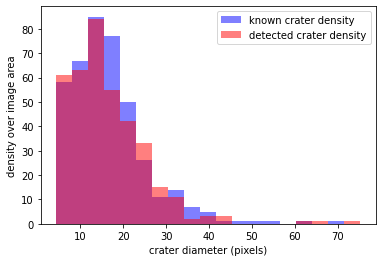

known crater count in image:  409
detected crater count in image:  376


In [13]:
an.plot_densities()

It looks like that bought us a bump in overall performance!

### 3. Classification

The final step in the pipeline is a binary classifier; PyCDA takes the proposals from the extractor, crops tiny images of the proposals from the input image, and feeds them to the classifier for prediction.
The default classifier is a small convolutional neural net that takes a 12x12 pixel cropped image of the crater as an input; it does a decent job of weeding out the bad detections.<br><br>
The first version of PyCDA does not come with any additional classifiers, but a user can easily use the CustomClassifier class to try a new one. PyCDA will automatically detect input dimensions, which makes plugging a custom model into the pipeline very easy; the user only needs to specify the filepath to the saved keras model and 'crater_pixels,' the number of pixels the crater candidate should occupy in the center of the cropped images.

In [14]:
from pycda.classifiers import CustomClassifier

#This is a new classifier that I trained using more parameters,
#regularization, and other fancy neural net stuff.
my_classifier = CustomClassifier(model_path='./pycda/models/classifier_12x12_2.h5', crater_pixels=6)
new_cda.classifier = my_classifier
third_pred = new_cda.get_prediction(image)

/Users/mklear/miniconda3/envs/pycda/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


In [15]:
third_pred.known_craters = new_prediction.known_craters
an.analyze(third_pred)

200 craters were properly detected.
Matching complete!


Detection Percentage: 48.9%

Precision: 0.7

Recall: 0.49

F1-Score: 0.58

False Discovery Rate: 0.3

False Negative Rate: 0.51

Branching Factor:  0.42

Quality Percentage: 40.6% 



Oops! Looks like I'd better stick with the default classifier...

# PyCDA: Fast, Flexible Crater Detection
Most users will have a very specific task in mind when using PyCDA; that's why it's designed to apply custom models and varied image formats for maximum flexibility. Use the CustomDetector and CustomClassifier classes to quickly deploy your models and get detecting!